In [1]:
from functions import *
from models import *

2024-10-18 11:02:04.562867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 11:02:04.584453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 11:02:04.591055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 11:02:04.607713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 11:02:05.584977: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Load rivers

In [3]:
import fiona
import geopandas as gpd
from shapely.geometry import shape
source_folder = '../data/external/raster_masks'
rivers = {}
for subdir, dirs, files in os.walk(source_folder):
    for i,file in enumerate(files):
        r,m = load_raster(os.path.join(subdir, file), False)
        #rius = list(img_per_river.keys())
        name = file.split('.')[0].split('bw_')[-1]
        rivers[name] = r
rivers.keys()

dict_keys(['Jorenbach', 'Seltenbach', 'Plattenbach', 'Riale_di_Motom', 'Ruisseau_des_Frassy', 'Kasperabach', 'Rausenbach', 'Rotenbachli', 'Ruisseau_de_Chatillon', 'Eibachli', 'Chrauchbach', 'Fiume_Peccia', 'Emme', 'LaVenoge_shapefile', 'Leiterbergbach', 'Stossbach', 'Torrent_de_Greffe', 'Tschagibach', 'Wasserfallenbach', 'La_Saufla', 'Guuhetbach', 'Schusselbach', 'LaBroye_shapefile', 'Usser_Bargelbach', 'La_Paudeze', 'Zauggenbach', 'Bisse-Neuf', 'Ragn_da_Colm', 'Calcascia', 'Raptgusa', 'swissTLMboiron', 'Guetentalbach', 'Tschermanner_Bach', 'Susasca', 'Riale_della_Fontana', 'Haagbach', 'Ri_dei_Calcestri', 'Maira_|_Mera', 'Ruisseau_de_la_Leyvra', 'Alplibach', 'Malbunbach', 'Aletenbach', 'I_Custiell', 'Bruederbach', 'Spitzalpelibach', 'Wiesenbach', 'El_Ri_Vall_Mala', 'Ruisseau_de_Pra_Gouma', 'Ruisseau_du_Perelet', 'le_boiron2', 'Ri_di_Piera'])

### Choose inputs

In [80]:
W = 256
filter_river = None#[3,11,12]
inputs = ['ndvi']#['ndvi','discharge', 'slope']#, ndvi, disch, slope' #'lst+ndvi' for ndvi inputs
conditioned = True
batch_size = 16
epochs = 50
model_name = "img_wise_CNN" #img_wise_CNN, UNet, transfer_learning_VGG16, CNN, img_2_img

In [81]:
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)
       
all_dir_paths    

{'lst': ['../data/preprocessed/lst/Hindereggbachli',
  '../data/preprocessed/lst/Plattenbach',
  '../data/preprocessed/lst/Rausenbach',
  '../data/preprocessed/lst/Riale_della_Valle',
  '../data/preprocessed/lst/Malbunbach',
  '../data/preprocessed/lst/Seltenbach',
  '../data/preprocessed/lst/Ruisseau_des_Frassy',
  '../data/preprocessed/lst/Rotenbachli',
  '../data/preprocessed/lst/Ruisseau_de_Pra_Gouma',
  '../data/preprocessed/lst/Torrent_de_Greffe',
  '../data/preprocessed/lst/Guuhetbach',
  '../data/preprocessed/lst/LaBroye_shapefile',
  '../data/preprocessed/lst/Harmedingebachli',
  '../data/preprocessed/lst/Hindertoss',
  '../data/preprocessed/lst/Ragn_da_Colm',
  '../data/preprocessed/lst/Raptgusa',
  '../data/preprocessed/lst/Alplibach',
  '../data/preprocessed/lst/La_Paudeze',
  '../data/preprocessed/lst/Bisse_de_Marais',
  '../data/preprocessed/lst/LaVenoge_shapefile',
  '../data/preprocessed/lst/Ramserlibachli',
  '../data/preprocessed/lst/Ri_dei_Calcestri',
  '../data/prep

In [82]:
total_data = {}
total_times = {}
complete_rivers = []
for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    
    if k != 'discharge' and k != 'slope':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)

            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
        
        data, times = load_data(v,W,list_rgb)
        
        filtered = [arr for arr in data.values() if arr.size > 0]

        total_data[k] = np.concatenate(filtered, axis=0)
        total_times[k] = times
        print(k,':' ,total_data[k].shape)

    elif k == 'discharge' or k == 'slope':
        total = []
        for p in v:
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                r,m = load_raster(file_path, False)
                var = resize_image(r, W,W)
                img_river = labels.count(p.split("/")[-1])
                var_input = np.tile(var, (img_river, 1, 1))
                total.append(var_input)
        
        total_data[k] = np.concatenate(total, axis=0)
        print(k,':' ,total_data[k].shape)


lst : (381, 256, 256, 3)
ndvi : (381, 256, 256)
wt : (381, 256, 256)
masked : (381, 256, 256, 3)
discharge : (132, 256, 256)
slope : (132, 256, 256)


In [83]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
river_encoded = encoder.fit_transform(np.array(labels).reshape(-1, 1))
# Mostrar el array resultante
print(river_encoded.shape)

(381, 50)


In [84]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (381, 256, 256, 3) (381, 256, 256)
targets shape: (381, 256, 256)


In [85]:
'''for i in range(lst.shape[0]):
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))
    axes[0].set_title('lst')

    axes[1].imshow(ndvi[i])
    axes[1].set_title('ndvi')

    axes[2].imshow(data_targets[i])
    axes[2].set_title('wt')

    if total_times['lst'][0][i] != total_times['ndvi'][0][i] or total_times['lst'][0][i] != total_times['wt'][0][i] or total_times['ndvi'][0][i] != total_times['wt'][0][i]:
        print('Time mismatch')

    plt.suptitle(f"For time {total_times['lst'][0][0]}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
'''

'for i in range(lst.shape[0]):\n    fig, axes = plt.subplots(1,3, figsize=(10,5))\n    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))\n    axes[0].set_title(\'lst\')\n\n    axes[1].imshow(ndvi[i])\n    axes[1].set_title(\'ndvi\')\n\n    axes[2].imshow(data_targets[i])\n    axes[2].set_title(\'wt\')\n\n    if total_times[\'lst\'][0][i] != total_times[\'ndvi\'][0][i] or total_times[\'lst\'][0][i] != total_times[\'wt\'][0][i] or total_times[\'ndvi\'][0][i] != total_times[\'wt\'][0][i]:\n        print(\'Time mismatch\')\n\n    plt.suptitle(f"For time {total_times[\'lst\'][0][0]}", fontsize=16)\n    plt.tight_layout()\n    plt.subplots_adjust(top=0.9)\n    plt.show()\n'

Convert inputs to gray images

'''masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)'''

Split data

In [86]:
if inputs != None:
    inputs_d = [total_data[inp] for inp in inputs]#[ndvi,discharge,slope] 

In [87]:
if inputs == None:
    train_index, validation_index, test_index = split_data(lst, data_targets)
    input_data = lst
else:
    # Lista de diferentes conjuntos de imágenes a combinar con LST
    additional_images = inputs_d # Añade todas las imágenes adicionales que quieras

    # Expande la dimensión de cada conjunto de imágenes para asegurar que tengan un canal extra
    expanded_images = [np.expand_dims(img, axis=-1) for img in additional_images]  # Cada imagen tendrá shape: (n_samples, 256, 256, 1)

    # Concatenar LST con todas las imágenes adicionales a lo largo del último eje (canales)
    combined_input = np.concatenate([lst] + expanded_images, axis=-1)  # LST (RGB) + todas las imágenes adicionales
    train_index, validation_index, test_index = split_data(combined_input, data_targets)
    input_data = combined_input
    

validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index, :]
validation_rivers = river_encoded[validation_index, :]

test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index, :]
test_rivers = river_encoded[test_index, :]

train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index, :]
train_rivers = river_encoded[train_index, :]



In [88]:
print(train_input.shape, train_target.shape, validation_input.shape, validation_target.shape, test_input.shape, test_target.shape, train_rivers.shape, validation_rivers.shape, test_rivers.shape)

(305, 256, 256, 4) (305, 256, 256) (38, 256, 256, 4) (38, 256, 256) (38, 256, 256, 4) (38, 256, 256) (305, 50) (38, 50) (38, 50)


## CNN simpler

#### Choose model

In [89]:
# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset

In [90]:
if conditioned:
    input_args = (input_shape, river_encoded.shape[1])
    model_input = [train_input, train_rivers]
    val_model_input = [validation_input, validation_rivers]
    test_model_input = [test_input, test_rivers]
else:
    input_args = input_shape
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input

if model_name == "img_wise_CNN":
    if conditioned:
        model = build_simplified_cnn_model_label(input_args[0], input_args[1])
    else:
        model = build_simplified_cnn_model(input_args)
elif model_name == 'CNN':
    model = build_cnn_model(input_args)
elif model_name == 'img_2_img':
    model = build_img_2_img_model(input_args)
elif model_name == 'UNet':
    model = build_unet(input_args)
elif model_name == 'transfer_learning_VGG16':
    model =  build_transfer_model(input_args)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 254, 254,  │        592 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 127, 127,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 125, 125,  │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 62, 62,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 123008)    │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 123058)    │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │  7,875,776 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 65536)     │  4,259,840 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 256, 256)  │          0 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,140,848 (46.31 MB)

 Trainable params: 12,140,848 (46.31 MB)

 Non-trainable params: 0 (0.00 B)

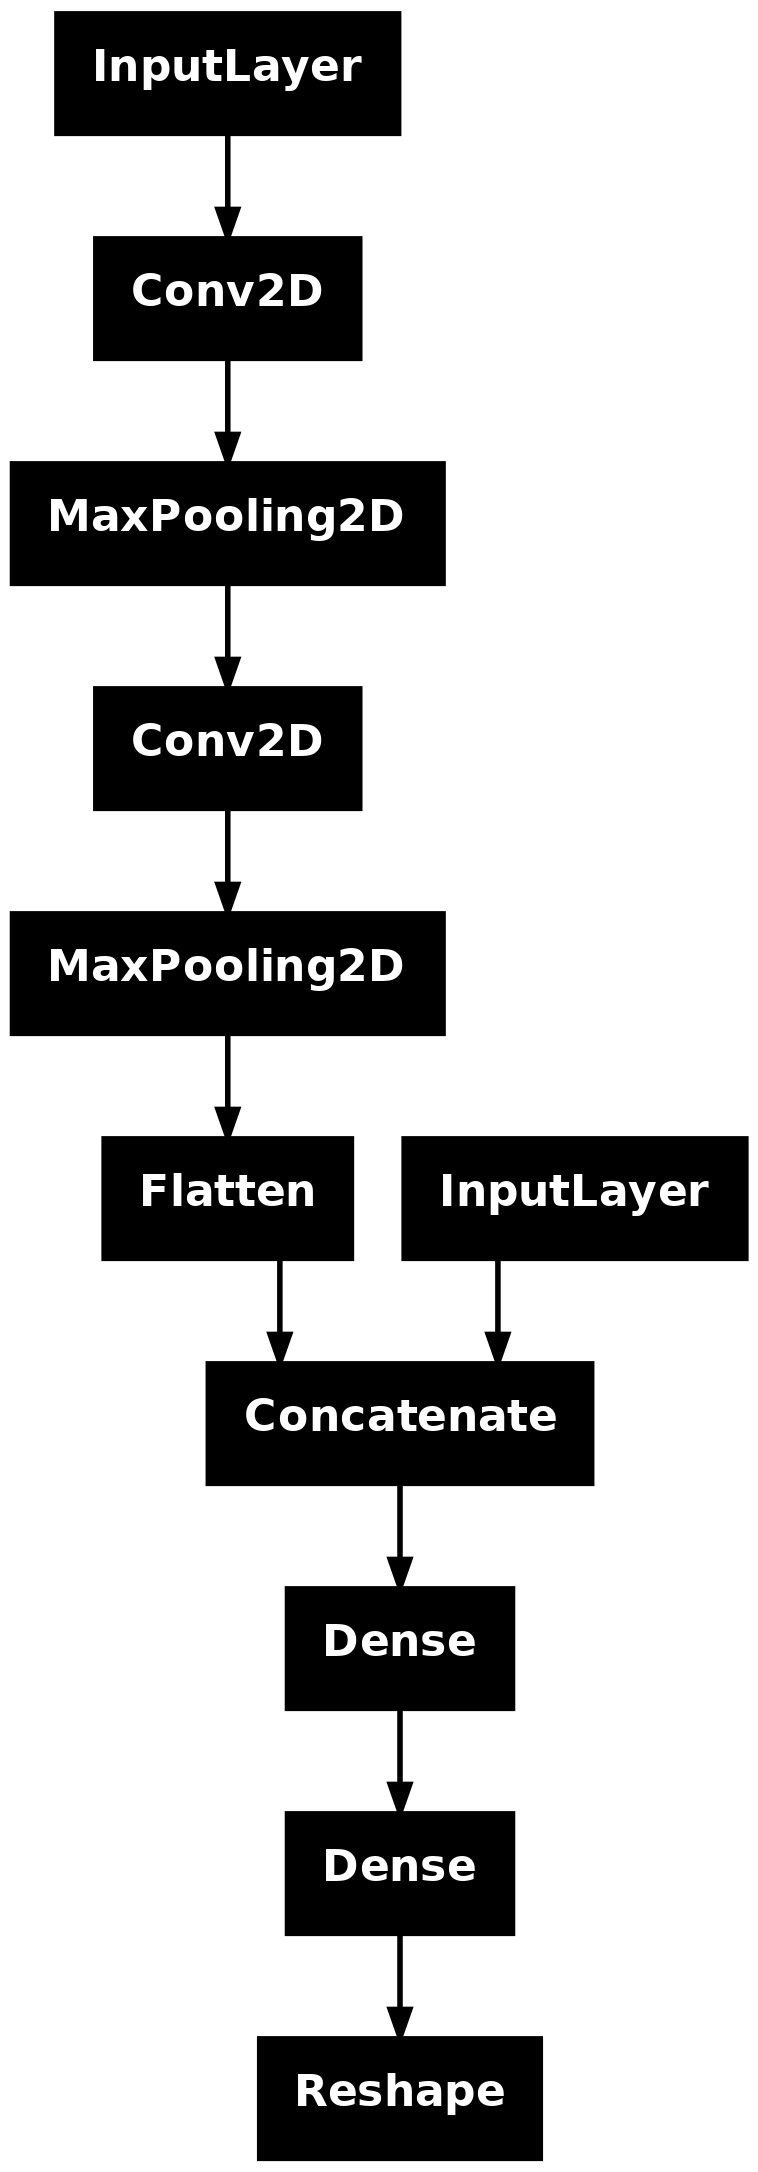

In [91]:
tf.keras.utils.plot_model(model)

In [92]:
#history = simplified_cnn_model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(validation_input, validation_target))
history = model.fit(model_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_model_input, validation_target))

Epoch 1/50


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_85', 'keras_tensor_91']. Received: the structure of inputs=('*', '*')
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.8343 - mae: 0.0801 - val_loss: 1.0572 - val_mae: 0.1107
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8375 - mae: 0.1173 - val_loss: 1.0401 - val_mae: 0.1613
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8331 - mae: 0.1434 - val_loss: 1.0276 - val_mae: 0.1296
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9562 - mae: 0.1310 - val_loss: 1.0257 - val_mae: 0.1274
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8043 - mae: 0.1260 - val_loss: 1.0258 - val_mae: 0.1254
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8083 - mae: 0.1200 - val_loss: 1.0223 - val_mae: 0.1414
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8376 - mae: 0.1298 - val_loss: 1.0307 - val_mae: 0.1102
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8253 - mae: 0.1092 - val_loss: 1.0183 - val_mae: 0.1485
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7882 - mae: 0

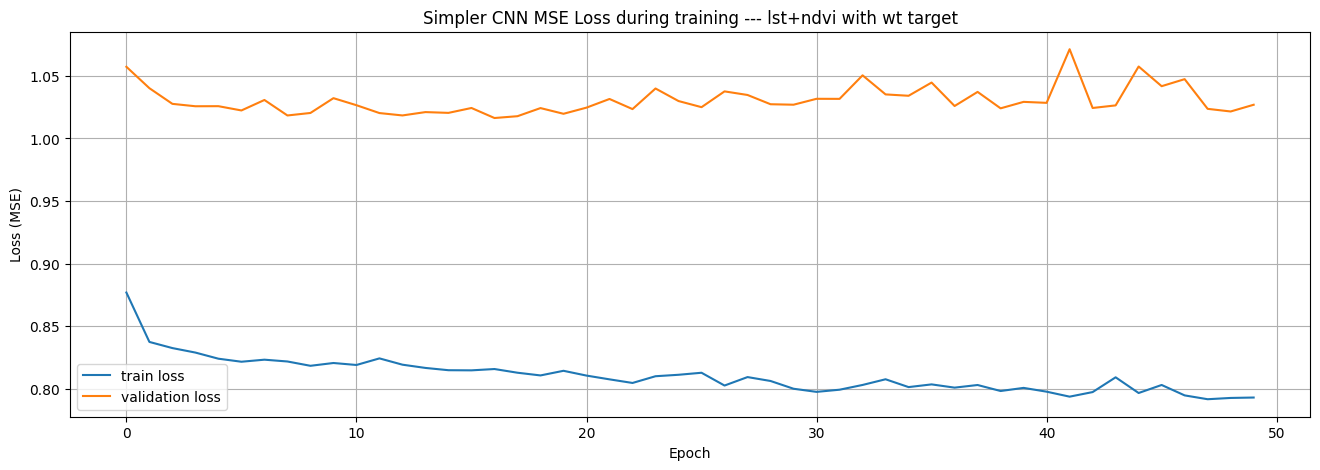

In [93]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [94]:
plt.savefig('../plots/cnn.png')

<Figure size 640x480 with 0 Axes>

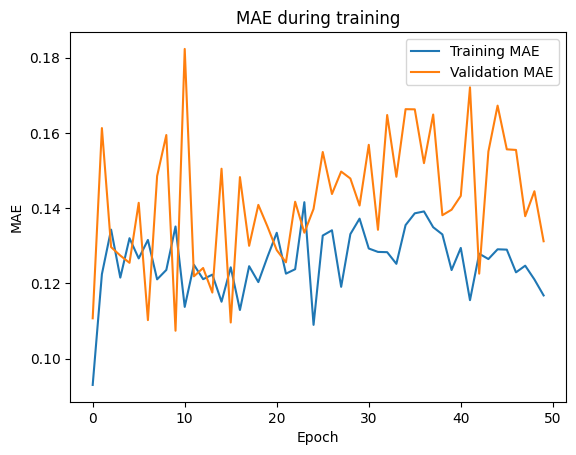

In [95]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [96]:
validation_prediction = model.predict(val_model_input)
test_prediction = model.predict(test_model_input)
results = {'MAE':0,'MSE':0,'RMSE':0,'R²':0,'MAPE (%)':0,'MSE sample-wise':0}

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Image wise metrics results

In [97]:
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    # Flatten the true and predicted values for this sample
    riv = rivers[labels[test_index[i]]].flatten()
    
    y_true_flatten = test_target[i].flatten()
    y_true_mask = y_true_flatten[riv != 0]

    y_pred_flatten = test_prediction[i].flatten()
    y_pred_mask = y_pred_flatten[riv != 0]

    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 8.990546, 'MSE': 124.63511, 'RMSE': 9.040779, 'R²': -43123580462518.76, 'MAPE (%)': 91.0664292542558, 'MSE sample-wise': 127.4859}


See what are the areas with more prediction error

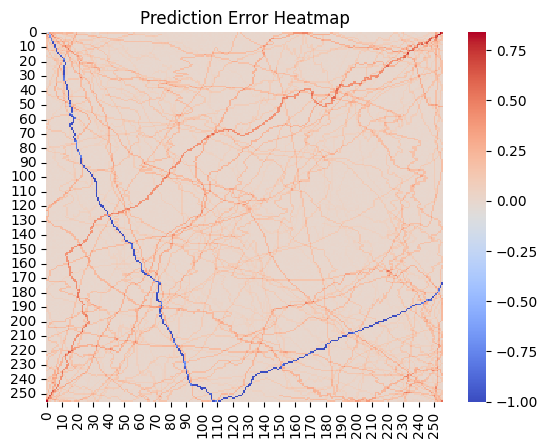

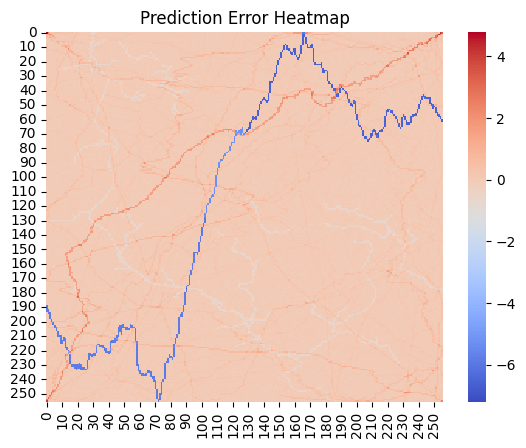

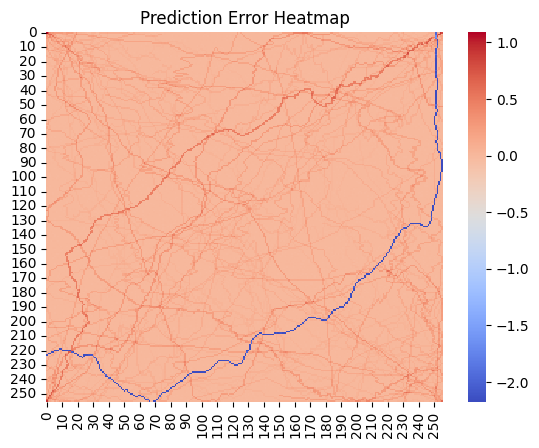

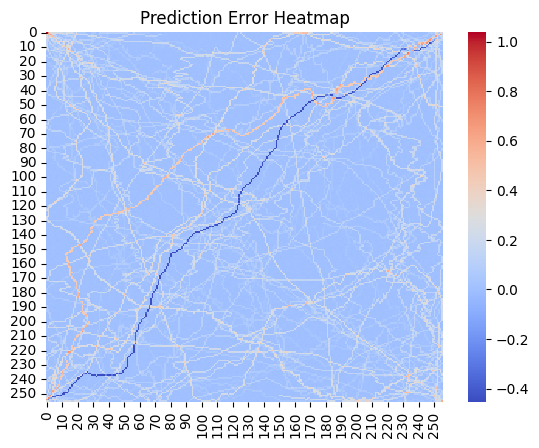

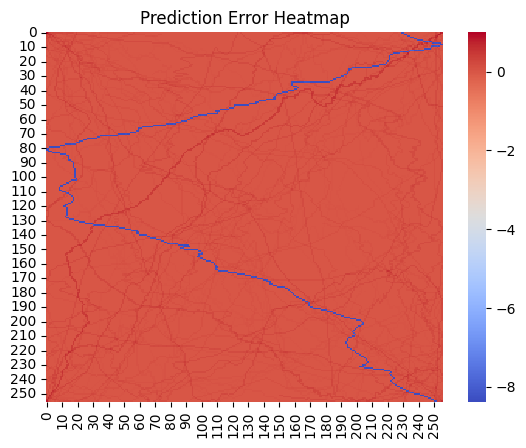

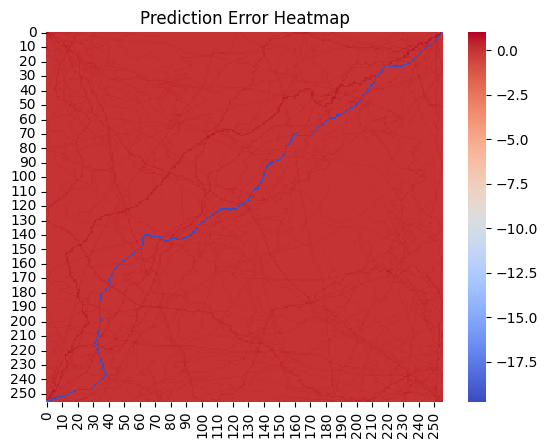

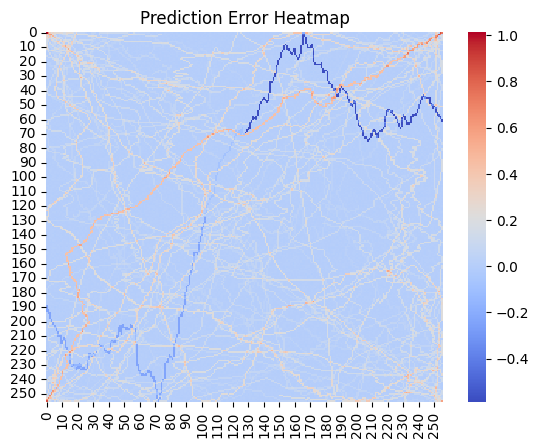

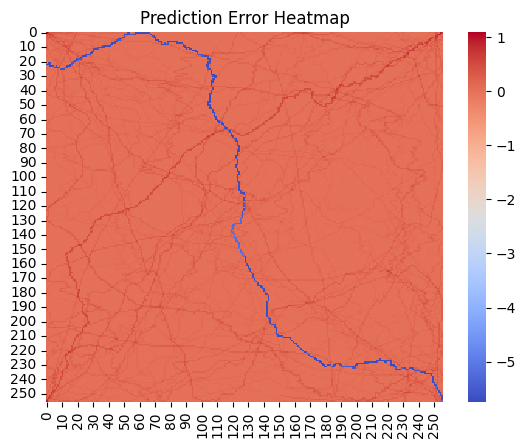

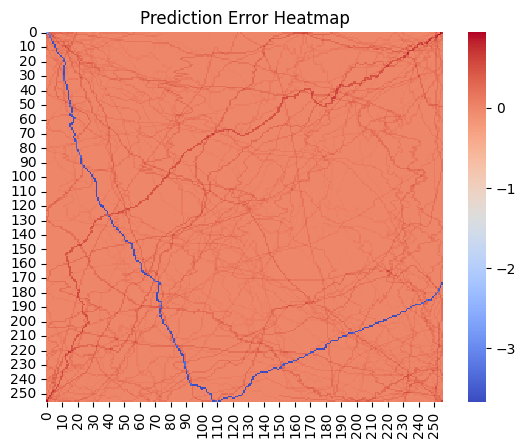

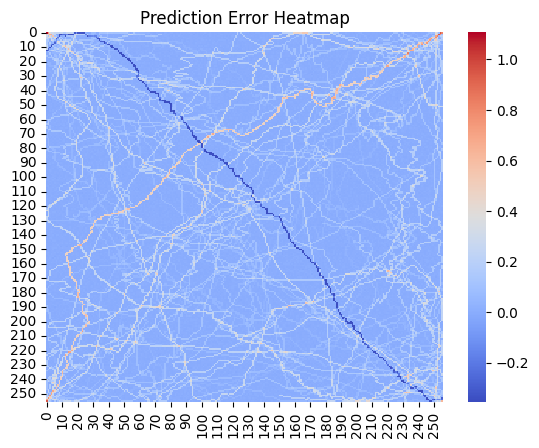

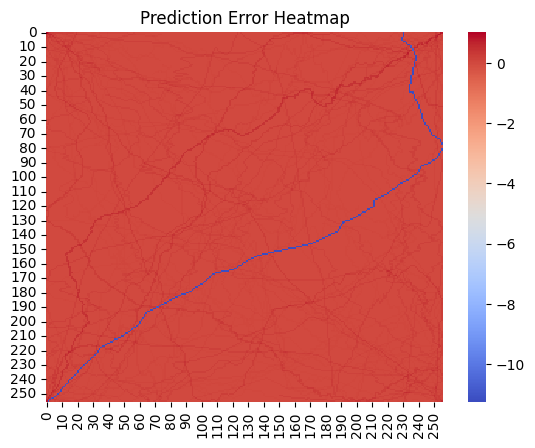

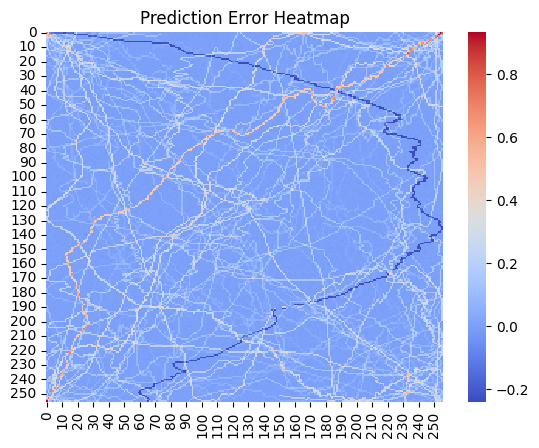

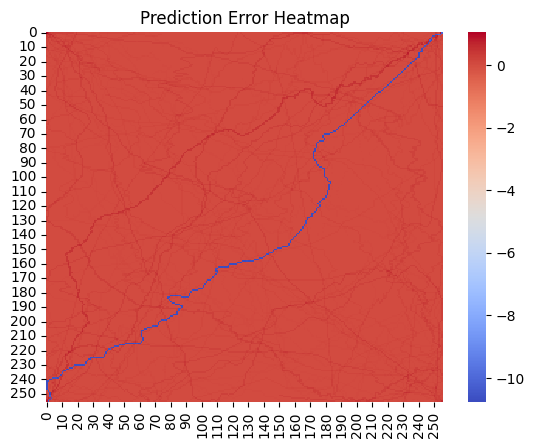

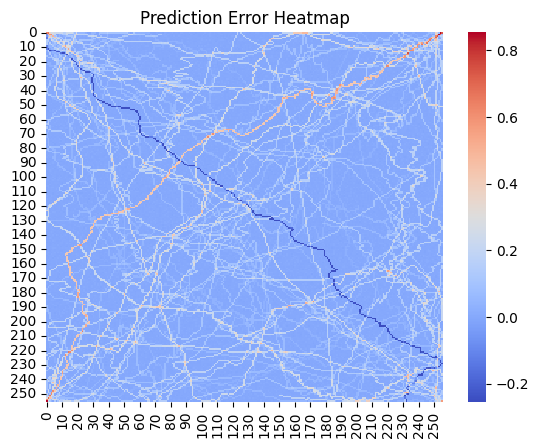

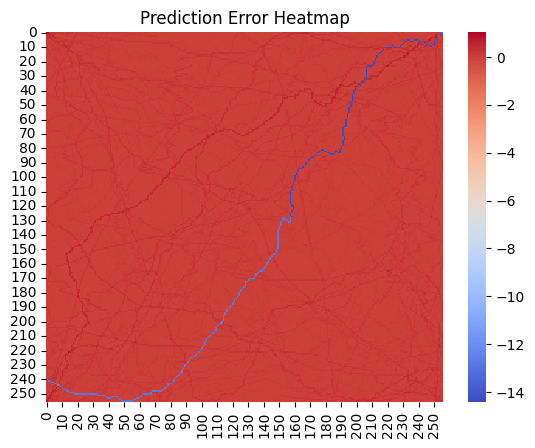

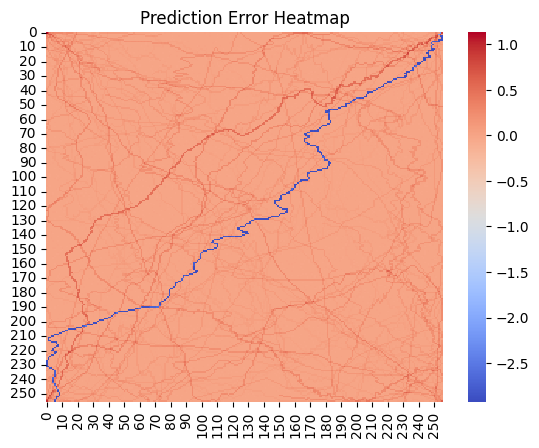

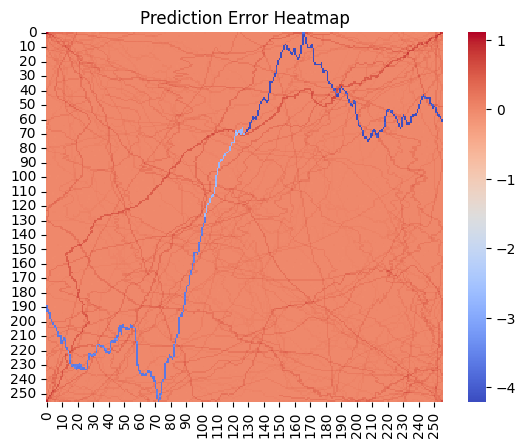

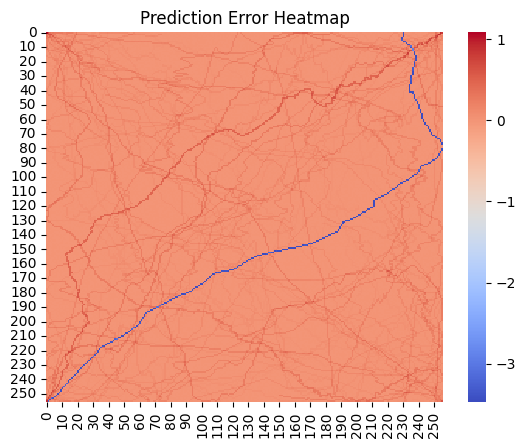

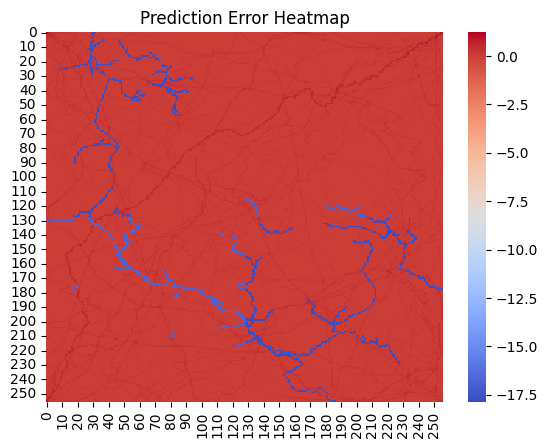

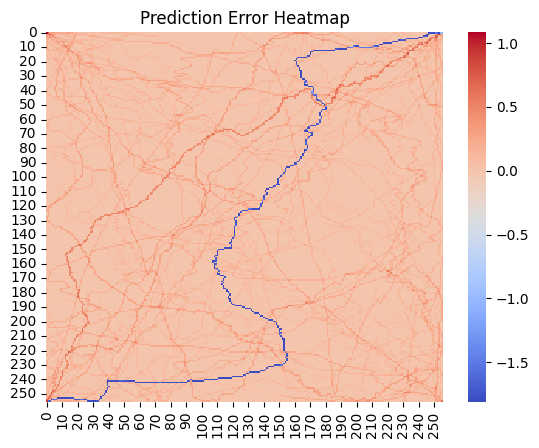

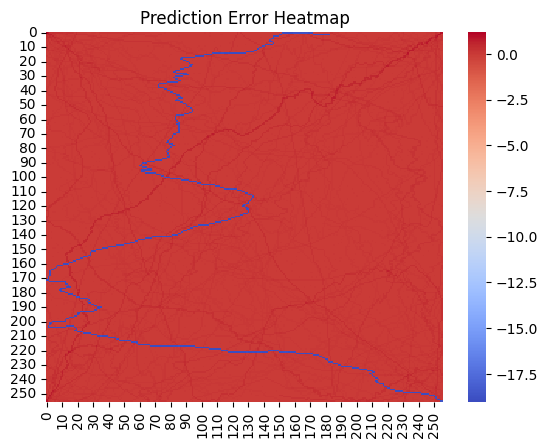

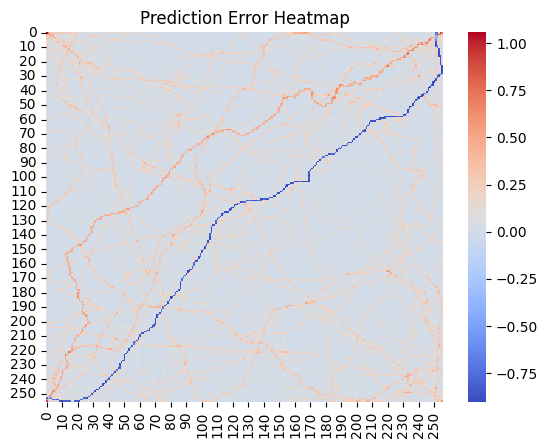

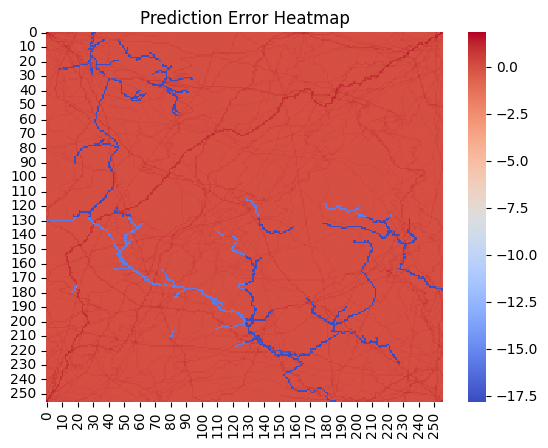

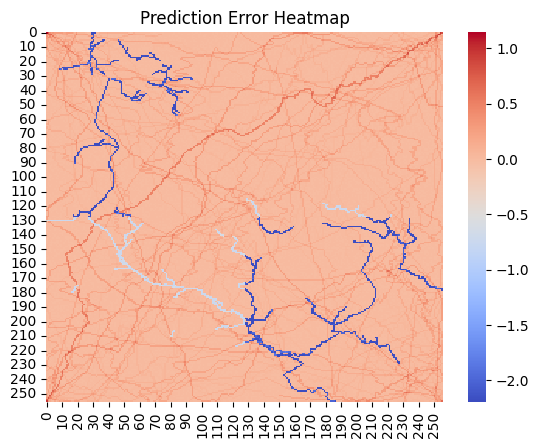

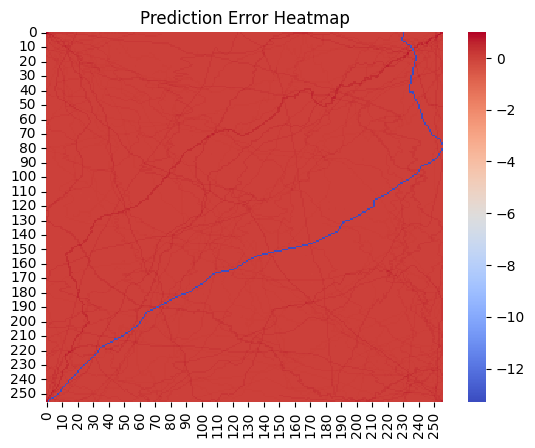

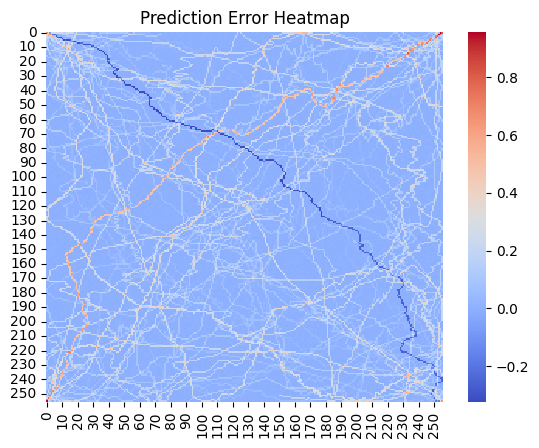

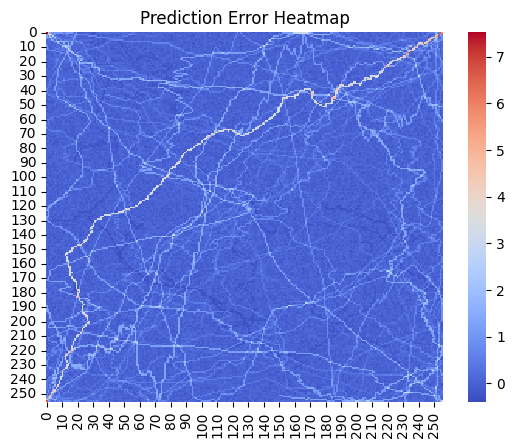

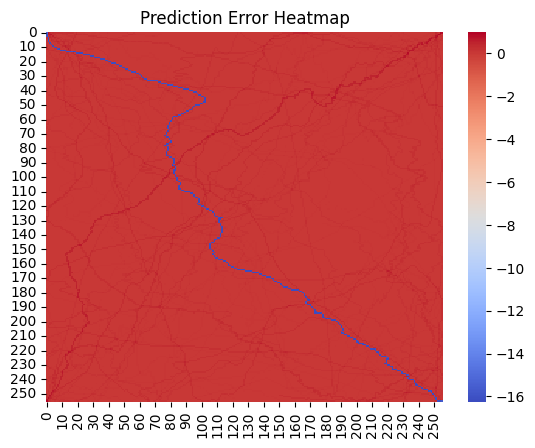

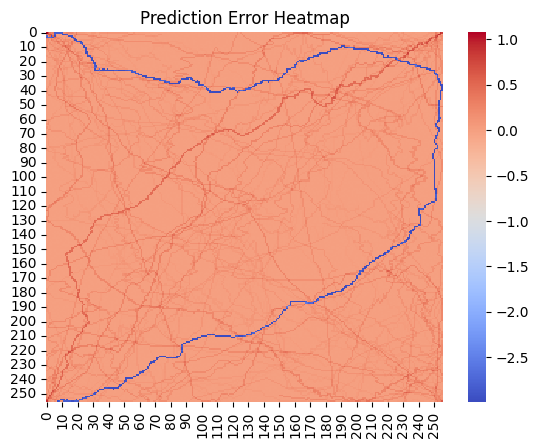

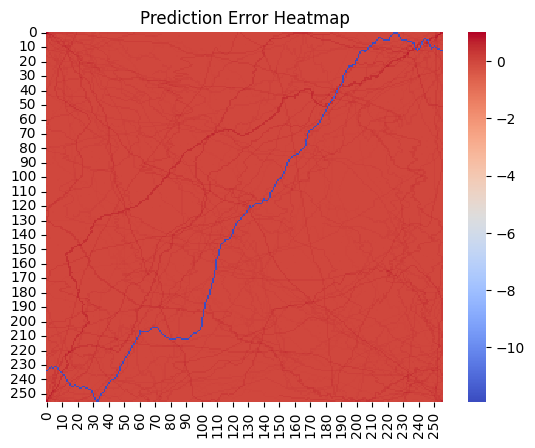

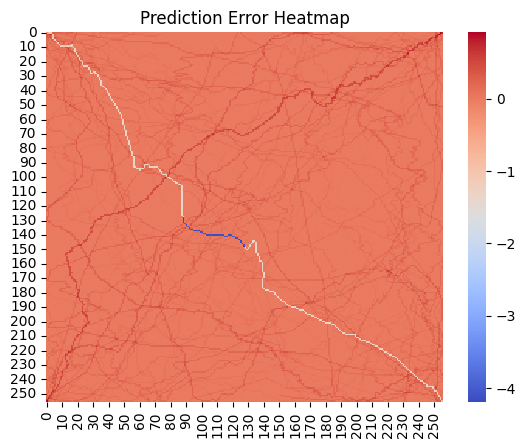

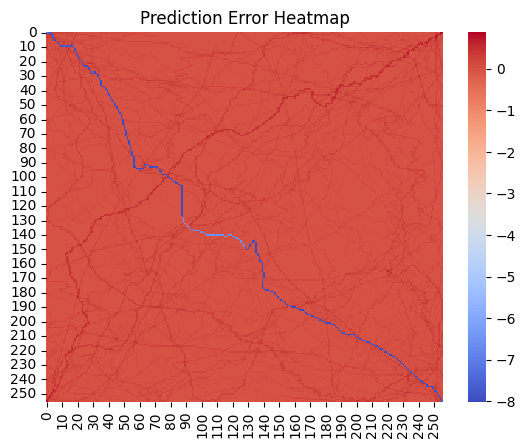

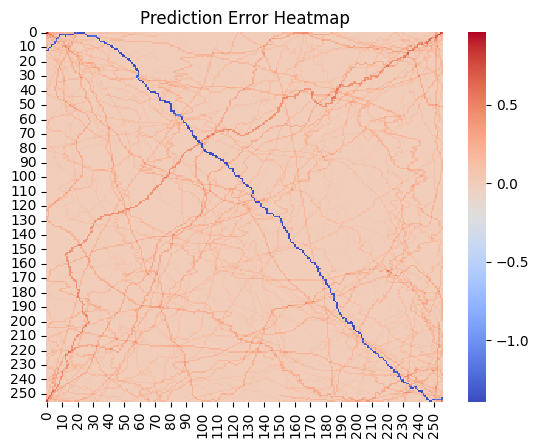

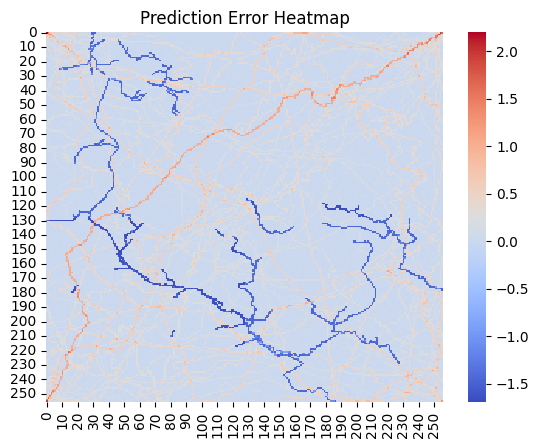

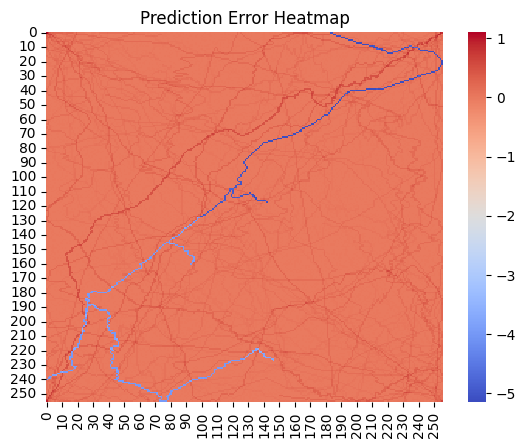

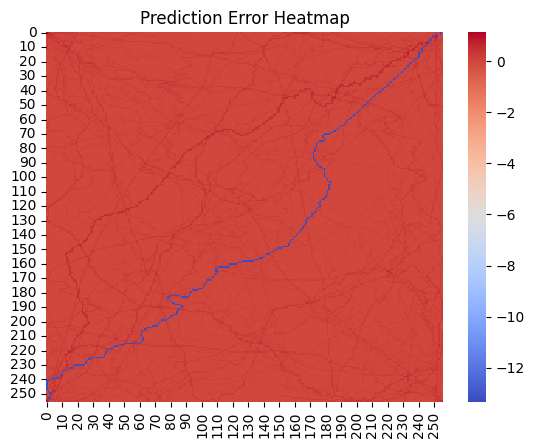

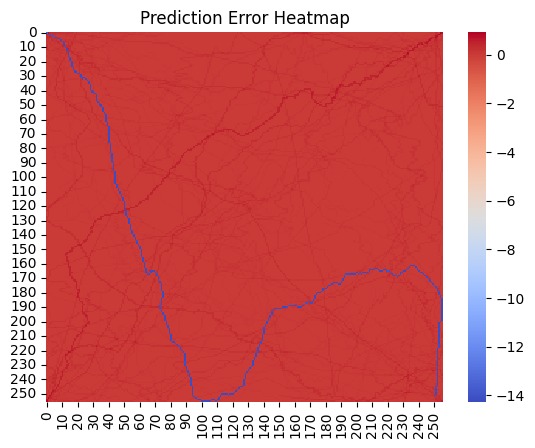

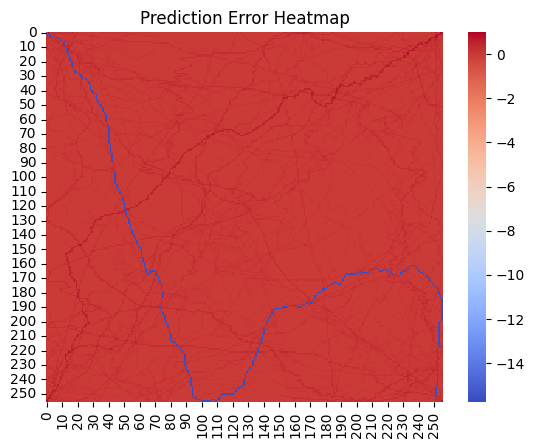

In [99]:
if len(validation_prediction.shape) == 4:
  validation_prediction=np.squeeze(validation_prediction, axis=3)

diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

In [100]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

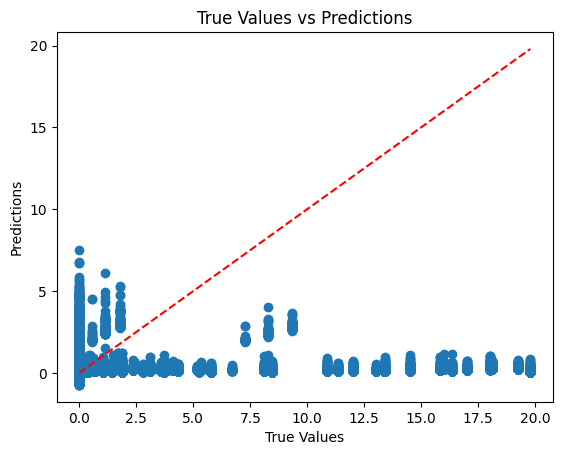

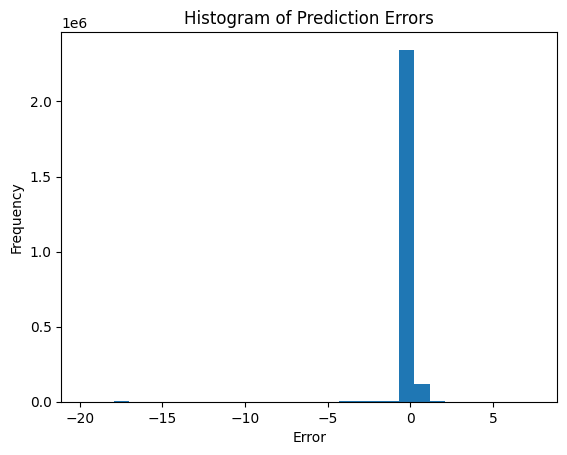

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [102]:
laabeel = 'label' if conditioned else 'no label'
var_inputs = '' if inputs == None else '_'.join(inputs)
variables = 'lst, '+var_inputs+', ' + laabeel


In [103]:
details = {'RMSE':mean_results['RMSE'],'Variables':variables,'Input': f'{len(np.unique(labels))} rivers', 'Output': 'wt', 'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')

In [104]:
pd.read_excel('../results/img_wise_CNN_results.xlsx')

RMSE                             Variables      Input Output  \
0    4.952849                             lst, ndvi   3 rivers     wt   
1    7.593136                             lst, ndvi   3 rivers     wt   
2    9.262160                             lst, ndvi   3 rivers     wt   
3    8.879040                             lst, ndvi   la Broye     wt   
4    7.453351                                   lst   3 rivers     wt   
5    7.748187                                   lst  10 rivers     wt   
6    6.894447                                   lst  10 rivers     wt   
7    6.043903                             lst, ndvi  10 rivers     wt   
8    7.795375                             lst, ndvi  10 rivers     wt   
9    6.939476               lst, ndvi, disch, slope  10 rivers     wt   
10   5.749361        lst, ndvi, disch, slope, label  10 rivers     wt   
11   8.393123        lst, ndvi, disch, slope, label   3 rivers     wt   
12   7.993154                            lst, label  10 rivers     wt   
13   7.332493                             lst, ndvi  10 rivers     wt   
14   8.561131                             lst, ndvi  10 rivers     wt   
15  10.669209     lst, ndvi, disch, slope, no label  10 rivers     wt   
16   7.870301     lst, ndvi, disch, slope, no label  10 rivers     wt   
17   8.667958                              lst,ndvi   3 rivers     wt   
18   2.732514            lst,ndvi, discharge, slope  13 rivers     wt   
19   6.584363  lst,ndvi, discharge, slope, no label  13 rivers     wt   
20   6.727011                     lstndvi, no label  50 rivers     wt   
21   5.927823                        lstndvi, label  50 rivers     wt   
22   7.242764                         lst, no label  50 rivers     wt   
23   6.853471                     lst, ndvino label  50 rivers     wt   
24   6.823829                        lst, ndvilabel  50 rivers     wt   
25   9.040779                      lst, ndvi, label  50 rivers     wt   

    Resolution  nº samples  Batch size  Epochs  
0          256          55           4      10  
1          256          55           4      50  
2          256          55           8      30  
3          256          20           4      50  
4          256          55           4      10  
5          256         119           4      10  
6          256         119          16      50  
7          256         119           8      50  
8          256         119           8      50  
9          256         119           8      50  
10         256         119           8      50  
11         256          39           8      50  
12         256         119           8      50  
13         256         119           8      50  
14         256         119           4      10  
15         256         119           4      10  
16         256         119           4      50  
17         256          39           4      10  
18         256         119           4      50  
19         256         119           4      50  
20         256         381          32      30  
21         256         381          32      30  
22         256         381           4      50  
23         256         381           4      50  
24         256         381           4      50  
25         256         381          16      50